In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import xmltodict
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient
from pycocotools.coco import COCO
import cv2
import random

In [2]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(2023)

In [3]:
from pathlib import Path
from PIL import Image



data_root = r'D:\Side_project\MedSAM\data\map_1-1_without_bbox'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#%% create a dataset class to load npz data and return back image embeddings and ground truth
class NpzDataset(Dataset): 
    """
    A PyTorch Dataset to load data from a json file in COCO format.

    ...
    Attributes
    ----------
    root_dir : str
        the root directory containing the images and annotations
    annotation_file : str
        name of the json file containing the annotations (in root_dir)
    transform : callable
        a function/transform to apply to each image

    Methods
    -------
    __getitem__(idx)
        returns the image, image path, and masks for the given index
    buid_total_mask(masks)
        combines the masks into a single mask
    """


    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())

        # Filter out image_ids without any annotations
        self.image_ids = [image_id for image_id in self.image_ids if len(self.coco.getAnnIds(imgIds=image_id)) > 0]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = self.root_dir / image_info['file_name']

        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)
        bboxes = []
        masks = []

        for ann in anns:
            x, y, w, h = ann['bbox']
            bboxes.append([x, y, x + w, y + h])
            mask = self.coco.annToMask(ann)
            masks.append(mask)

        if self.transform:
            image, masks, bboxes = self.transform(image, masks, np.array(bboxes))

        bboxes = np.stack(bboxes, axis=0)
        masks = np.stack(masks, axis=0)
        return image, torch.tensor(masks).float()

    def get_totalmask(self, masks):
        """get all masks in to one image
        ARGS:
            masks (List[Tensor]): list of masks
        RETURNS:
            total_gt (Tensor): all masks in one image

        """
        total_gt = torch.zeros_like(masks[0][0,:,:])
        for k in range(len(masks[0])):
            total_gt += masks[0][k,:,:]
        return total_gt

In [4]:
class ResizeAndPad:
    """
    Resize and pad images and masks to a target size.

    ...
    Attributes
    ----------
    target_size : int
        the target size of the image
    transform : ResizeLongestSide
        a transform to resize the image and masks
    """

    def __init__(self, target_size):
        self.target_size = target_size
        self.transform = ResizeLongestSide(target_size)
        self.to_tensor = transforms.ToTensor()

    def __call__(self, image, masks, bboxes):
        # Resize image and masks
        og_h, og_w, _ = image.shape
        image = self.transform.apply_image(image)
        masks = [torch.tensor(self.transform.apply_image(mask)) for mask in masks]
        image = self.to_tensor(image)

        # Pad image and masks to form a square
        _, h, w = image.shape
        max_dim = max(w, h)
        pad_w = (max_dim - w) // 2
        pad_h = (max_dim - h) // 2

        padding = (pad_w, pad_h, max_dim - w - pad_w, max_dim - h - pad_h)
        image = transforms.Pad(padding)(image)
        masks = [transforms.Pad(padding)(mask) for mask in masks]

        # Adjust bounding boxes
        bboxes = self.transform.apply_boxes(bboxes, (og_h, og_w))
        bboxes = [[bbox[0] + pad_w, bbox[1] + pad_h, bbox[2] + pad_w, bbox[3] + pad_h] for bbox in bboxes]

        return image, masks, bboxes

In [5]:
train_root = r'D:\Side_project\MedSAM\data\map_1-1_without_bbox\train'
train_anno = r'D:\Side_project\MedSAM\data\map_1-1_without_bbox\train\_annotations.coco.json'

valid_root = r'D:\Side_project\MedSAM\data\map_1-1_without_bbox\valid'
valid_anno = r'D:\Side_project\MedSAM\data\map_1-1_without_bbox\valid\_annotations.coco.json'

def load_datasets(img_size):
    """ load the training and validation datasets in PyTorch DataLoader objects
    ARGS:
        img_size (Tuple(int, int)): image size
    RETURNS:
        train_dataloader (DataLoader): training dataset
        val_dataloader (DataLoader): validation dataset

    """
    transform = ResizeAndPad(1024)
    traindata = NpzDataset(root_dir=train_root,
                           annotation_file=train_anno,
                           transform=transform)
    valdata = NpzDataset(root_dir=valid_root,
                         annotation_file=valid_anno,
                         transform=transform)
    train_dataloader = DataLoader(traindata,
                                  batch_size=4,
                                  shuffle=True)
    val_dataloader = DataLoader(valdata,
                                batch_size=1)
    return train_dataloader, val_dataloader

In [6]:
trainloader, validloader = load_datasets(1024)
sample_img = trainloader.dataset[0][0]
sample_mask = trainloader.dataset[0][1]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [7]:
print(f'shape of sample_img: {sample_img.shape}')
print(f'shape fo sample_mask: {sample_mask.shape}')

shape of sample_img: torch.Size([3, 1024, 1024])
shape fo sample_mask: torch.Size([1, 1024, 1024])


In [8]:
import torch.nn as nn
import torch.nn.functional as F


class ModelSimple(nn.Module):
    """
    Wrapper for the sam model to to fine-tune the model on a new dataset

    ...
    Attributes:
    -----------
    freeze_encoder (bool): freeze the encoder weights
    freeze_decoder (bool): freeze the decoder weights
    freeze_prompt_encoder (bool): freeze the prompt encoder weights
    transform (ResizeLongestSide): resize the images to the model input size

    Methods:
    --------
    setup(): load the model and freeze the weights
    forward(images, points): forward pass of the model, returns the masks and iou_predictions
    """

    def __init__(self, freeze_encoder=True, freeze_decoder=False, freeze_prompt_encoder=True,
                 model_path=r'D:\Side_project\MedSAM\work_dir\MedSAM\medsam_vit_b.pth'):
        super().__init__()
        self.freeze_encoder = freeze_encoder
        self.freeze_decoder = freeze_decoder
        self.freeze_prompt_encoder = freeze_prompt_encoder
        self.model_path = model_path
        # we need this to make the input image size compatible with the model
        self.transform = ResizeLongestSide(1024) #This is 1024, because sam was trained on 1024x1024 images

    def setup(self):
        # TODO your path here
        self.model = sam_model_registry['vit_b'](self.model_path)
        # to speed up training time, we normally freeze the encoder and decoder
        if self.freeze_encoder:
            for param in self.model.image_encoder.parameters():
                param.requires_grad = False
        if self.freeze_prompt_encoder:
            for param in self.model.prompt_encoder.parameters():
                param.requires_grad = False
        if self.freeze_decoder:
            for param in self.model.mask_decoder.parameters():
                param.requires_grad = False
        self.transfrom = ResizeLongestSide(self.model.image_encoder.img_size)

        return self.model
    def forward(self, images):
        _, _, H, W = images.shape # batch, channel, height, width
        image_embeddings = self.model.image_encoder(images) # shape: (1, 256, 64, 64)
        # get prompt embeddings without acutally any prompts (uninformative)
        sparse_embeddings, dense_embeddings = self.model.prompt_encoder(
            points=None,
            boxes=None,
            masks=None,
        )

        # get low resolution masks and iou predictions
        # mulitmask_output=False means that we only get one mask per image,
        # otherwise we would get three masks per image
        low_res_masks, iou_predictions = self.model.mask_decoder(
            image_embeddings=image_embeddings,
            image_pe=self.model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings, # sparse_embeddings shape: (1, 0, 256)
            dense_prompt_embeddings=dense_embeddings, # dense_embeddings shape: (1, 256, 256)
            multimask_output=False,
        )
        # postprocess the masks to get the final masks and resize them to the original image size
        masks = F.interpolate(
            low_res_masks, # shape: (1, 1, 256, 256)
            (H, W),
            mode="bilinear",
            align_corners=False,
        )
        # shape masks after interpolate: torch.Size([1, 1, 1024, 1024])
        return masks, iou_predictions

In [9]:
from torch.types import Device
#data
global train
global test
global annot

#model
global batch_size
global epochs
global lr
global weight_decay
global DEVICE

# TODOD adjust, if needed!!!!
batch_size = 1
epochs = 30
lr = 0.001
weight_decay = 0.0005
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# loss
global alpha
global gamma
alpha = 0.8
gamma = 2
evaluate=False

cuda


(224, 224, 3)


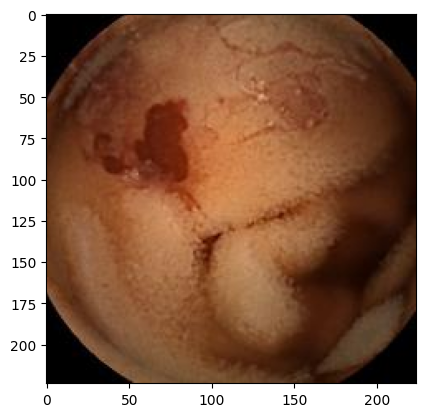

In [10]:
# TODO add your path
sample_path = r'D:\Side_project\MedSAM\data\map_1-1_without_bbox\valid\img-53-_262_png.rf.a63a9e957ba8420266abe154c182c8c5.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_path), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
print(sample_img.shape)

In [11]:
a = torch.randn((1024, 1024))
len(a.shape), a.unsqueeze(dim=0).unsqueeze(dim=0).shape

(2, torch.Size([1, 1, 1024, 1024]))

In [12]:
from functools import partial
import torch.nn as nn
import torch.nn.functional as F
import torch
import datetime
import logging
from torch.utils.tensorboard.writer import SummaryWriter


log_save_path = r'D:\Side_project\MedSAM\ipynbs\finetunesam\finetune_3_log'
logging.basicConfig(level=logging.INFO, filename=f'{log_save_path}/Log.log', filemode='a')

def get_totalmask(masks):
    """get all masks in to one image
    ARGS:
        masks (torch.Tensor): shape: (N, H, W) where N is the number of masks
                              masks H,W is usually 1024,1024
    RETURNS:
        total_gt (torch.Tensor): all masks in one image

    """
    total_gt = torch.zeros_like(masks[0,:,:])
    for k in range(len(masks)):
        total_gt += masks[k,:,:]
    return total_gt



class FocalLoss(nn.Module):
    """ Computes the Focal loss. """

    def __init__(self):
        super().__init__()

    def forward(self, inputs, targets):

        logging.info(f'FocalLoss: {inputs.shape=}, {targets.shape=}')
        # inputs = inputs.flatten()
        # print(f'{inputs.shape=}, {targets.shape=}')
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1 - BCE_EXP)**gamma * BCE

        return focal_loss


class DiceLoss(nn.Module):
    """ Computes the Dice loss. """

    def __init__(self):
        super().__init__()

    def forward(self, inputs, targets, smooth=1):
        logging.info(f'DiceLoss: {inputs.shape=}, {targets.shape=}')

        inputs = F.sigmoid(inputs)
        # print(f'before flatten: {inputs.shape=}, {targets.shape=}')
        # inputs = inputs.flatten()
        # print(f'{inputs.shape=}')
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / \
            (inputs.sum() + targets.sum() + smooth)
        return 1 - dice



def criterion(x, y):
    """ Combined dice and focal loss.
    ARGS:
        x: (torch.Tensor) the model output
        y: (torch.Tensor) the target
    RETURNS:
        (torch.Tensor) the combined loss

    """
    focal, dice = FocalLoss(), DiceLoss()
    y = y.to(DEVICE)
    x = x.to(DEVICE)
    # print(f'{x.shape=}, {y.shape=}')
    batch_size = x.shape[0]
    logging.info(f'Criterion before zip: {x.shape=}, {y.shape=}')

    if len(y.shape) == 2:
        logging.info(f'original y shape {y.shape=} need to match x shape {x.shape=}, start unsqueeze...')
        y = y.unsqueeze(dim=0).unsqueeze(dim=0)
        logging.info(f'After squeeze: {y.shape=}, {x.shape=}')

    

    losses = []
    for x, y in zip(x, y):
        logging.info(f'Criterion: {x.shape=}, {y.shape=}')
        focal_loss = 20 * focal(x, y)
        dice_loss = dice(x, y)
        losses.append(focal_loss + dice_loss)

    return sum(losses) / batch_size

def train_one_epoch(model, trainloader, optimizer, epoch_idx, tb_writer):
    """ Runs forward and backward pass for one epoch and returns the average
    batch loss for the epoch.
    ARGS:
        model: (nn.Module) the model to train
        trainloader: (torch.utils.data.DataLoader) the dataloader for training
        optimizer: (torch.optim.Optimizer) the optimizer to use for training
        epoch_idx: (int) the index of the current epoch
        tb_writer: (torch.utils.tensorboard.writer.SummaryWriter) the tensorboard writer
    RETURNS:
        last_loss: (float) the average batch loss for the epoch

    """
    running_loss = 0.
    for i, (image, masks) in enumerate(trainloader):

        image = image.to(DEVICE)
        optimizer.zero_grad()
        pred, _ = model(image)
        # masks = masks[0].to(DEVICE)
        # total_mask = get_totalmask(masks)
        pred = pred.to(DEVICE)
        loss = criterion(pred, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    i = len(trainloader)
    last_loss = running_loss / i
    print(f'running_loss: {running_loss}')
    print(f'batch_loss for batch {i}: {last_loss}')
    tb_x = epoch_idx * len(trainloader) + i + 1
    tb_writer.add_scalar('Loss/train', last_loss, tb_x)
    running_loss = 0.
    return last_loss


def train_fn():
    """ Trains the model for the given number of epochs."""
    bestmodel_path = ""
    model = ModelSimple()
    model.setup()
    model.to(DEVICE)
    img_size = model.model.image_encoder.img_size
    trainloader, validloader = load_datasets(img_size=img_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_valid_loss = float('inf')
    timestamp_writer = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    writer = SummaryWriter(r'D:\Side_project\MedSAM\ipynbs\finetunesam\finetune_3', f"trainer_{timestamp_writer}") # TODO your path here
    for epch in tqdm(range(epochs)): # type: ignore
        running_vloss = 0.
        model.train(True)
        avg_batchloss = train_one_epoch(
            model, trainloader, optimizer, epch, writer)

        with torch.no_grad():
            for images, masks in validloader:
                model.to(DEVICE)
                images = images.to(DEVICE)
                masks = masks[0].to(DEVICE)
                total_mask = get_totalmask(masks)
                total_mask = total_mask.to(DEVICE)
                model.eval()
                preds, iou = model(images)
                preds = preds.to(DEVICE)
                vloss = criterion(preds, total_mask)
                running_vloss += vloss.item()
        avg_vloss = running_vloss / len(validloader)
        tb_x = epch * len(trainloader) + len(validloader) + 1
        writer.add_scalar('Loss/valid', avg_vloss, tb_x)
        # writer.add_image
        print(f'epoch: {epch}, avg_vloss: {avg_vloss}')
        save_name = f'epoch={epch}_avg_vloss={avg_vloss}.pth'
        save_path = Path(r'D:\Side_project\MedSAM\ipynbs\finetunesam\finetune_3_map_without_bbox')
        save_path.mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), rf'{save_path}\{save_name}')
        if avg_vloss < best_valid_loss:
          best_valid_loss = avg_vloss
          save_name = f'best_epoch={epch}_best_avg_vloss={best_valid_loss}.pth'
          print(f'best valid loss: {best_valid_loss}')
          torch.save(model.state_dict(), rf'{save_path}\{save_name}')


In [13]:
from timeit import default_timer as timer
start_time = timer()
train_fn()
end_timer = timer()

print(f"Training time: {end_timer - start_time:.3f}")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


  0%|          | 0/30 [00:00<?, ?it/s]

running_loss: 661.3076418638229
batch_loss for batch 260: 2.543490930245473
epoch: 0, avg_vloss: 2.262620637243278
best valid loss: 2.262620637243278


  3%|▎         | 1/30 [06:57<3:21:41, 417.30s/it]

running_loss: 646.3974153995514
batch_loss for batch 260: 2.4861439053828898
epoch: 1, avg_vloss: 2.2986368708226874


  7%|▋         | 2/30 [13:42<3:11:28, 410.30s/it]

running_loss: 613.6702493429184
batch_loss for batch 260: 2.360270189780455
epoch: 2, avg_vloss: 2.439883518949779


 10%|█         | 3/30 [20:23<3:02:43, 406.04s/it]

running_loss: 613.0460669994354
batch_loss for batch 260: 2.357869488459367
epoch: 3, avg_vloss: 2.271247996681038


 13%|█▎        | 4/30 [27:01<2:54:28, 402.64s/it]

running_loss: 615.7871351242065
batch_loss for batch 260: 2.368412058170025
epoch: 4, avg_vloss: 2.273882391809047


 17%|█▋        | 5/30 [33:45<2:47:59, 403.20s/it]

running_loss: 608.7807421684265
batch_loss for batch 260: 2.3414643929554866
epoch: 5, avg_vloss: 2.2862374567894186


 20%|██        | 6/30 [40:24<2:40:43, 401.80s/it]

running_loss: 612.1020938158035
batch_loss for batch 260: 2.354238822368475
epoch: 6, avg_vloss: 2.2890764826559016


 23%|██▎       | 7/30 [46:58<2:33:03, 399.30s/it]

running_loss: 612.1511954069138
batch_loss for batch 260: 2.354427674641976
epoch: 7, avg_vloss: 2.287210390942307


 27%|██▋       | 8/30 [53:19<2:24:19, 393.61s/it]

running_loss: 623.9231127500534
batch_loss for batch 260: 2.3997042798078976
epoch: 8, avg_vloss: 2.284024347747423


 30%|███       | 9/30 [59:42<2:16:29, 390.00s/it]

running_loss: 685.8568904399872
batch_loss for batch 260: 2.637911117076874
epoch: 9, avg_vloss: 2.2878402485244576


 33%|███▎      | 10/30 [1:06:18<2:10:37, 391.87s/it]

running_loss: 614.54916203022
batch_loss for batch 260: 2.3636506231931538
epoch: 10, avg_vloss: 2.2713240092741573


 37%|███▋      | 11/30 [1:12:37<2:02:51, 387.96s/it]

running_loss: 607.3357871770859
batch_loss for batch 260: 2.3359068737580224
epoch: 11, avg_vloss: 2.2838071073152095


 40%|████      | 12/30 [1:19:02<1:56:10, 387.26s/it]

running_loss: 609.4029933214188
batch_loss for batch 260: 2.3438576666208415
epoch: 12, avg_vloss: 2.312414551603383


 43%|████▎     | 13/30 [1:25:39<1:50:33, 390.21s/it]

running_loss: 614.1511209011078
batch_loss for batch 260: 2.3621196957734916
epoch: 13, avg_vloss: 2.7529100175104837


 47%|████▋     | 14/30 [1:31:59<1:43:11, 386.98s/it]

running_loss: 622.8463057279587
batch_loss for batch 260: 2.3955627143383027
epoch: 14, avg_vloss: 2.29119381228626


 50%|█████     | 15/30 [1:38:22<1:36:27, 385.82s/it]

running_loss: 614.3856092691422
batch_loss for batch 260: 2.3630215741120852
epoch: 15, avg_vloss: 2.378220830840626


 53%|█████▎    | 16/30 [1:44:44<1:29:44, 384.59s/it]

running_loss: 614.2922616004944
batch_loss for batch 260: 2.362662544617286
epoch: 16, avg_vloss: 2.2752909427401664


 57%|█████▋    | 17/30 [1:51:03<1:22:58, 382.94s/it]

running_loss: 610.941047668457
batch_loss for batch 260: 2.349773260263296
epoch: 17, avg_vloss: 2.3181071966543967


 60%|██████    | 18/30 [1:57:26<1:16:36, 383.03s/it]

running_loss: 611.2662717103958
batch_loss for batch 260: 2.3510241219630608
epoch: 18, avg_vloss: 2.2805056042141385


 63%|██████▎   | 19/30 [2:03:46<1:10:04, 382.19s/it]

running_loss: 617.4406912326813
batch_loss for batch 260: 2.3747718893564667
epoch: 19, avg_vloss: 2.2752020541735534


 67%|██████▋   | 20/30 [2:10:08<1:03:41, 382.10s/it]

running_loss: 610.558586359024
batch_loss for batch 260: 2.3483022552270154
epoch: 20, avg_vloss: 2.277149653069361


 70%|███████   | 21/30 [2:16:27<57:11, 381.22s/it]  

running_loss: 610.1471471786499
batch_loss for batch 260: 2.346719796840961
epoch: 21, avg_vloss: 2.270523187301168


 73%|███████▎  | 22/30 [2:22:48<50:49, 381.20s/it]

running_loss: 609.5406448841095
batch_loss for batch 260: 2.3443870957081137
epoch: 22, avg_vloss: 2.276417507065667


 77%|███████▋  | 23/30 [2:29:10<44:29, 381.40s/it]

running_loss: 610.2085273265839
batch_loss for batch 260: 2.346955874333015
epoch: 23, avg_vloss: 2.2923901423640634


 80%|████████  | 24/30 [2:35:29<38:03, 380.63s/it]

running_loss: 609.6269822120667
batch_loss for batch 260: 2.3447191623541026
epoch: 24, avg_vloss: 2.2783438022109284


 83%|████████▎ | 25/30 [2:41:54<31:48, 381.80s/it]

running_loss: 609.7801516056061
batch_loss for batch 260: 2.345308275406177
epoch: 25, avg_vloss: 2.2739375605893772


 87%|████████▋ | 26/30 [2:48:15<25:26, 381.52s/it]

running_loss: 612.7282674312592
batch_loss for batch 260: 2.35664718242792
epoch: 26, avg_vloss: 2.283968258178097


 90%|█████████ | 27/30 [2:54:34<19:02, 380.84s/it]

running_loss: 611.8600338697433
batch_loss for batch 260: 2.353307822575936
epoch: 27, avg_vloss: 2.3485396008838637


 93%|█████████▎| 28/30 [3:01:29<13:02, 391.02s/it]

running_loss: 610.2635089159012
batch_loss for batch 260: 2.3471673419842354
epoch: 28, avg_vloss: 2.271643442669134


 97%|█████████▋| 29/30 [3:07:51<06:28, 388.37s/it]

running_loss: 608.2866011857986
batch_loss for batch 260: 2.3395638507146104
epoch: 29, avg_vloss: 2.2719494899113974


100%|██████████| 30/30 [3:14:09<00:00, 388.33s/it]

Training time: 11651.914


In [14]:
# use my custom SAM model wrapper class
model_trained= ModelSimple()
model_trained.setup()
model_trained.load_state_dict(torch.load(r'D:\Side_project\MedSAM\ipynbs\finetunesam\finetune_3_map_without_bbox\epoch=29_avg_vloss=2.2719494899113974.pth'))

<All keys matched successfully>

In [15]:
with torch.no_grad():
    model_trained.load_state_dict(torch.load(r'D:\Side_project\MedSAM\ipynbs\finetunesam\finetune_3_map_without_bbox\epoch=29_avg_vloss=2.2719494899113974.pth', map_location=torch.device('cpu')))
    model_trained.eval()
    img_size = model_trained.model.image_encoder.img_size
    print(f'img_size: {img_size}')
    print(f'img_size: {model_trained.model.image_encoder.img_size}')
    # TODO your code here

img_size: 1024
img_size: 1024


In [16]:
ori_sam_predictor = SamPredictor(model_trained.model)

In [21]:
ts_img_path = Path(r'D:\Side_project\MedSAM\data\map_1-1_without_bbox\valid')
ts_gt_path = Path(r'D:\Side_project\MedSAM\data\map_1-1_gastrointestinal_coco\map_val')

test_img_list = list((ts_img_path).glob('*.jpg'))
test_gt_list = list((ts_gt_path).glob('*.png'))
len(test_img_list), len(test_gt_list)

(261, 411)

In [22]:
# random select a test case
img_idx = np.random.randint(len(test_img_list))
image_data = Image.open(str(test_img_list[img_idx]))
image_data = transforms.Resize(size=(256, 256))(image_data)
image_data = np.array(image_data)
if image_data.shape[-1]>3 and len(image_data.shape)==3:
    image_data = image_data[:,:,:3]
if len(image_data.shape)==2:
    image_data = np.repeat(image_data[:,:,None], 3, axis=-1)
# read ground truth (gt should have the same name as the image) and simulate a bounding box
def get_bbox_from_mask(mask):
    
    '''Returns a bounding box from a mask'''
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = mask.shape
    ratio = 256/224
    x_min = max(0, x_min*ratio - np.random.randint(0, 20))
    x_max = min(W, x_max*ratio + np.random.randint(0, 20))
    y_min = max(0, y_min*ratio - np.random.randint(0, 20))
    y_max = min(H, y_max*ratio + np.random.randint(0, 20))

    return np.array([x_min, y_min, x_max, y_max])

gt_data = Image.open(str(test_gt_list[img_idx]))
gt_data = transforms.Resize(size=(256, 256))(gt_data)
gt_data = np.array(gt_data)
bbox_raw = get_bbox_from_mask(gt_data)


# preprocess: cut-off and max-min normalization
lower_bound, upper_bound = np.percentile(image_data, 0.5), np.percentile(image_data, 99.5)
image_data_pre = np.clip(image_data, lower_bound, upper_bound)
image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
image_data_pre[image_data==0] = 0
image_data_pre = np.uint8(image_data_pre)
H, W, _ = image_data_pre.shape

# predict the segmentation mask using the original SAM model
ori_sam_predictor.set_image(image_data_pre)
ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=None, box=bbox_raw, multimask_output=False)

ValueError: too many values to unpack (expected 2)

In [18]:
model_trained.model = model_trained.model.to('cuda')

In [19]:
# predict the segmentation mask using the fine-tuned model
# resize image to 3*1024*1024
sam_transform = ResizeLongestSide(model_trained.model.image_encoder.img_size)
resize_img = sam_transform.apply_image(image_data_pre)
resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
input_image = model_trained.model.preprocess(resize_img_tensor[None,:,:,:]) # (1, 3, 1024, 1024)
print(input_image.shape)
assert input_image.shape == (1, 3, model_trained.model.image_encoder.img_size, model_trained.model.image_encoder.img_size), 'input image should be resized to 1024*1024'

with torch.no_grad():
    # pre-compute the image embedding
    ts_img_embedding = model_trained.model.image_encoder(input_image)
    # convert box to 1024x1024 grid
    sam_trans = ResizeLongestSide(model_trained.model.image_encoder.img_size)
    bbox = sam_trans.apply_boxes(bbox_raw, (H, W))
    print(f'{bbox_raw=} -> {bbox=}')
    box_torch = torch.as_tensor(bbox, dtype=torch.float, device=device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 4) -> (B, 1, 4)
    
    sparse_embeddings, dense_embeddings = model_trained.model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    medsam_seg_prob, _ = model_trained.model.mask_decoder(
        image_embeddings=ts_img_embedding.to(device), # (B, 256, 64, 64)
        image_pe=model_trained.model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )
    medsam_seg_prob = torch.sigmoid(medsam_seg_prob)
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    print(medsam_seg.shape)

torch.Size([1, 3, 1024, 1024])
bbox_raw=array([  8.85714286,  14.14285714, 147.28571429, 102.14285714]) -> bbox=array([[ 35.42857143,  56.57142857, 589.14285714, 408.57142857]])
(256, 256)


In [20]:
ori_sam_dsc = compute_dice_coefficient(gt_data>0, ori_sam_seg>0)
medsam_dsc = compute_dice_coefficient(gt_data>0, medsam_seg>0)
print('Original SAM DSC: {:.4f}'.format(ori_sam_dsc), 'MedSAM DSC: {:.4f}'.format(medsam_dsc))

Original SAM DSC: 0.0000 MedSAM DSC: 0.0000


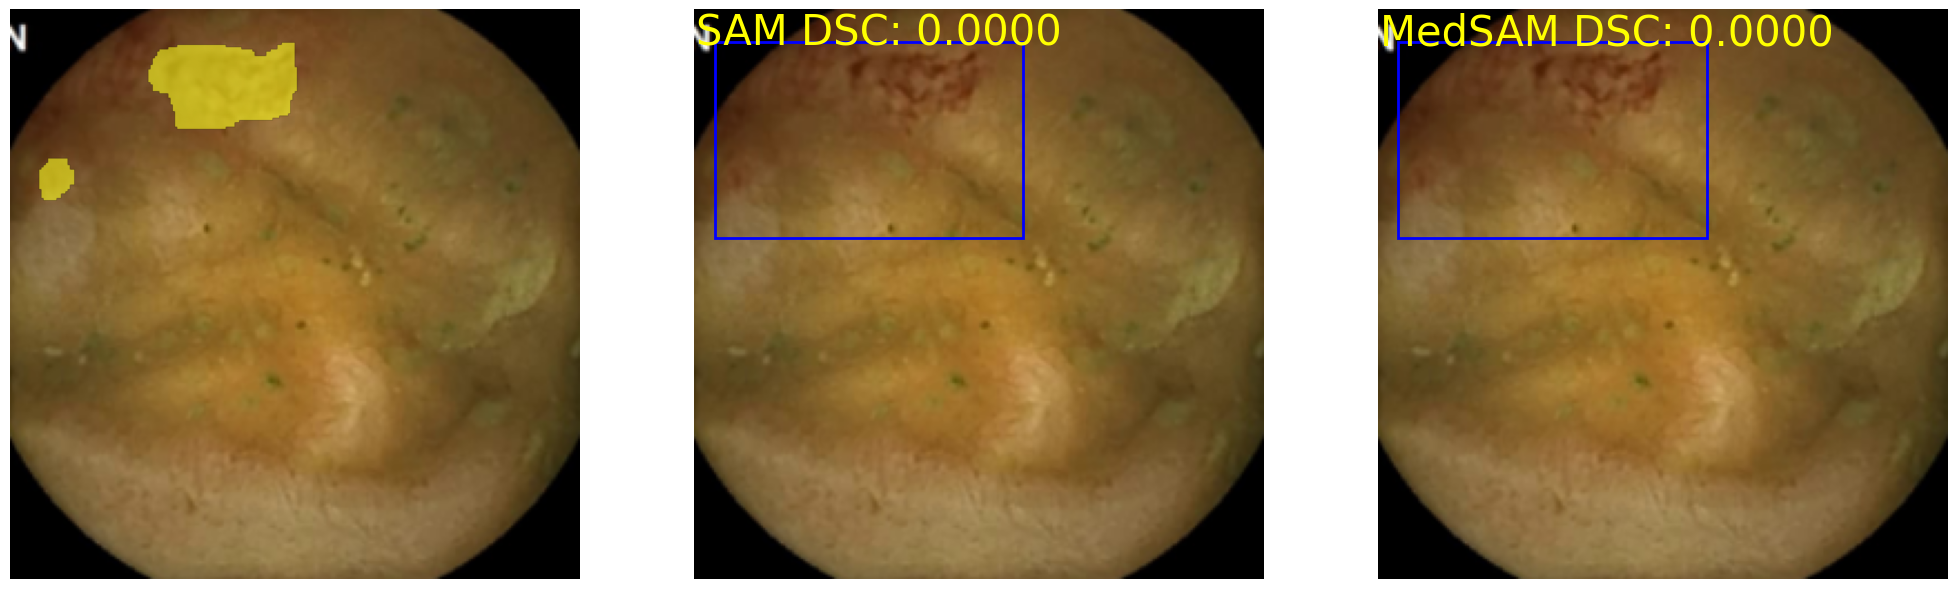

In [21]:
#%% visualize the segmentation results of the middle slice
# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))    

_, axs = plt.subplots(1, 3, figsize=(25, 25))
axs[0].imshow(image_data)
show_mask(gt_data>0, axs[0])
# show_box(box_np[img_id], axs[0])
# axs[0].set_title('Mask with Tuned Model', fontsize=20)
axs[0].axis('off')

axs[1].imshow(image_data)
show_mask(ori_sam_seg, axs[1])
show_box(bbox_raw, axs[1])
# add text to image to show dice score
axs[1].text(0.5, 0.5, 'SAM DSC: {:.4f}'.format(ori_sam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
# axs[1].set_title('Mask with Untuned Model', fontsize=20)
axs[1].axis('off')

axs[2].imshow(image_data)
show_mask(medsam_seg, axs[2])
show_box(bbox_raw, axs[2])
# add text to image to show dice score
axs[2].text(0.5, 0.5, 'MedSAM DSC: {:.4f}'.format(medsam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
# axs[2].set_title('Ground Truth', fontsize=20)
axs[2].axis('off')
plt.show()  
plt.subplots_adjust(wspace=0.01, hspace=0)
# save plot
# plt.savefig(join(model_save_path, test_npzs[npz_idx].split('.npz')[0] + str(img_id).zfill(3) + '.png'), bbox_inches='tight', dpi=300)
plt.close()

In [ ]:
from utils.demo import BboxPromptDemo

Button(description='clear', style=ButtonStyle())

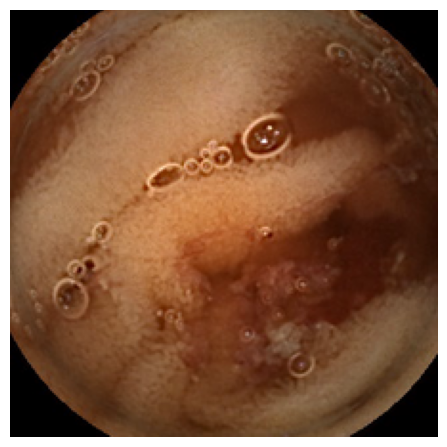

Button(description='save', style=ButtonStyle())

In [ ]:
# abdomen CT
img = r"D:\Side_project\MedSAM\data\gastrointestinal_coco\train\img- (1).png"
model_trained.model.eval()
bbox_prompt_demo = BboxPromptDemo(model_trained.model)
bbox_prompt_demo.show(img)